# Data Pipe Proto

In [1]:
import os
import h5py
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
import cudf
import datashader as ds, pandas as pd
from colorcet import fire
import datashader.transfer_functions as tf
import cuspatial
from tqdm import tqdm

In [2]:
filename = "data/satellite/requested_files_1/requested_files/A2020258175000.L2_LAC_OC.x.nc"

In [3]:
%%time
h5file = h5py.File(filename, 'r')
out_df = cudf.from_pandas(pd.concat([pd.DataFrame(h5file['navigation_data']['latitude'][()]), pd.DataFrame(h5file['navigation_data']['longitude'][()]), pd.DataFrame(h5file['geophysical_data']['chlor_a'][()])], axis = 1, keys = ['lat', 'lon', 'chlor']).stack().reset_index(drop=True))
start_date = "01/01/{}".format(h5file['scan_line_attributes']['year'][0])
date_1 = datetime.strptime(start_date, "%m/%d/%Y")
dateset_date = date_1 + timedelta(days=h5file['scan_line_attributes']['day'][0].item())
out_df['date'] = [dateset_date] * out_df.shape[0]
out_df = out_df.loc[(out_df['chlor'] != -32767.0)]

CPU times: user 893 ms, sys: 617 ms, total: 1.51 s
Wall time: 3.33 s


In [4]:
out_df.shape

(1531, 4)

In [5]:
out_df.head()

,lat,lon,chlor,date
182655,43.712784,-77.795525,2.063078,2020-09-15
182656,43.709061,-77.814217,2.073534,2020-09-15
185353,43.714680,-77.963722,2.038017,2020-09-15
185893,43.717697,-78.006073,2.039376,2020-09-15
185894,43.713802,-78.025192,2.085391,2020-09-15


In [6]:
out_df.shape

(1531, 4)

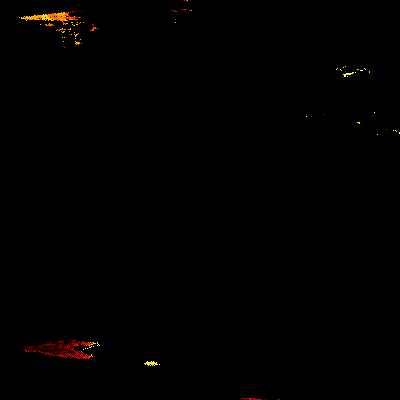

In [7]:
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(out_df.to_pandas(), 'lon', 'lat', ds.mean('chlor'))
tf.set_background(tf.shade(agg, cmap=fire),"black")

# Creating Large (Macro) Dataframe

In [8]:
data_path = './data/satellite/'
data_files = []
for subdir, dirs, files in os.walk('./data/satellite/'):
    for filename in files:
        filepath = subdir + os.sep + filename

        if filepath.endswith(".nc"):
            data_files.append(filepath)

In [9]:
len(data_files)

1093

In [ ]:
%%time
comp_df = cudf.DataFrame()
dfs = []
for file in tqdm(data_files):
    h5file = h5py.File(file, 'r')
    out_df = cudf.from_pandas(pd.concat([pd.DataFrame(h5file['navigation_data']['latitude'][()]), pd.DataFrame(h5file['navigation_data']['longitude'][()]), pd.DataFrame(h5file['geophysical_data']['chlor_a'][()])], axis = 1, keys = ['lat', 'lon', 'chlor']).stack().reset_index(drop=True))
    start_date = "01/01/{}".format(h5file['scan_line_attributes']['year'][0])
    date_1 = datetime.strptime(start_date, "%m/%d/%Y")
    dateset_date = date_1 + timedelta(days=h5file['scan_line_attributes']['day'][0].item())
    out_df['date'] = [dateset_date] * out_df.shape[0]
    out_df = out_df.loc[(out_df['chlor'] != -32767.0)]
    dfs.append(out_df)
comp_df = cudf.concat(dfs)

 94%|█████████▎| 1022/1093 [01:48<00:06, 11.19it/s]

In [ ]:
comp_df.head()

In [ ]:
comp_df.shape

In [ ]:
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(comp_df.to_pandas(), 'lon', 'lat', ds.mean('chlor'))
tf.set_background(tf.shade(agg, cmap=fire),"black")

Data has now been merged into one macro dataframe. Now, we perform point-in-polygon tests to select only the 5 great lakes.

# Point-In-Polygon Tests

In [ ]:
shapefiles_dir = './data/shapefiles/'
shapefiles = []
# making shapefiles directory
for filename in os.listdir(shapefiles_dir):
    if filename.endswith('.shp'):
        shapefiles.append(shapefiles_dir + filename)
shapefiles # now we have all 5 shapefiles

In [ ]:
# trial with 1 shapefile
huron = cuspatial.read_polygon_shapefile(shapefiles[1]) # read shapefile

In [ ]:
%%time
huron_df = cuspatial.point_in_polygon(comp_df['lon'] , comp_df['lat'], huron[0], huron[1], huron[2]['x'], huron[2]['y'])

In [ ]:
huron_df[0].value_counts()

In [ ]:
huron_chlor = comp_df[huron_df[0]]

In [ ]:
huron_chlor

In [ ]:
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(huron_chlor[huron_chlor['date'] == datetime.strptime("10/01/2020", "%m/%d/%Y")].to_pandas(), 'lon', 'lat', ds.mean('chlor'))
tf.set_background(tf.shade(agg, cmap=fire),"black")

In [ ]:
huron_chlor.to_csv('huron.csv', index = False)

In [ ]:
from sqlalchemy import create_engine
import pandas as pd

# postgres doesn't like capitals or spaces

df = huron_chlor.to_pandas()
df.columns = [c.lower() for c in df.columns]

engine = create_engine('postgres://admin:secret@db:5432/postgres')

df.to_sql("chlora", engine, if_exists = "replace", index = False, method = "multi", chunksize = 1_000_000)